In [1]:
!pip install networkx gensim

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Created wheel for smart-open: filename=smart_open-1.11.1-py3-none-any.whl size=95261 sha256=e74fc6649b5efe41dbe5a996f68262cd77428ba55543a547ab7fedcfc8cf1a23
  Stored in directory: c:\users\yfana\appdata\local\pip\cache\wheels\8a\c2\d3\16192a758e3f7d7661e23d86dc92a65f2e0a8f98600140f24d
Successfully built smart-open


In [1]:
import networkx as nx
import numpy as np
import os
import time
import csv
import pandas as pd
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

unable to import 'smart_open.gcs', disabling that module


# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [2]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=20732):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    true_edges = set(true_edges)
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        head, tail = np.random.choice(nodes, 2)
        if head != tail and (head, tail) not in true_edges and (head, tail) not in false_edges:
            false_edges.add((head, tail))    
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [3]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]['weight'])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]['weight'] / p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]['weight'])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]['weight'] / q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [4]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]

def generate_first_order_random_walk(graph, alias_nodes, walk_length=10, start_node=None):
    """
    simulate a random walk starting from start node and considering the first order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else:
            break

    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, walk_length=10, start_node=None):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            break

    return walk

### Network Embedding Algorithms

In [5]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
   # print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
   # print("trainig time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("trainig time: %.4f" % (time.time()-st))
    
    return model

### Scorer

In [6]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv.vectors[model.wv.index2word.index(u)]
        v = model.wv.vectors[model.wv.index2word.index(v)]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return roc_auc_score(y_true, y_score)

# Link Prediction

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [74]:
map_auc_scores = list()
# deepwalk_auc_scores.mean()
# node2vec_auc_scores.mean()
# node_dim
# num_walks
# walk_length
# num_false_edges
# p
# q

In [75]:
user_file = "data/train.csv"
valid_file = "data/valid.csv"
print("In train file:")
train_edges = load_data(user_file)
valid_edges = load_data(valid_file)
graph = construct_graph_from_edges(train_edges)
print("In valid file:")
valid_graph = construct_graph_from_edges(valid_edges)

In train file:
number of nodes: 8347
number of edges: 100000
In valid file:
number of nodes: 5388
number of edges: 19268


Link prediction is a task to prediction unseen edges based on graph information. Let's use cross validation to check their performance in the link prediction task.

In [78]:
np.random.seed(2)

# parameters need to be tuned
for num_walks in range(10,12):
    for walk_length in range(10,12):
        node_dim = 10
        num_false_edges=20732
        p = 0.5
        q = 0.5

        false_edges = generate_false_edges(train_edges+valid_edges,num_false_edges)

        # construct the graph and preprocess transition probabilities
        graph = construct_graph_from_edges(train_edges)
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)


        # ------------------------------------------ choose one model here--------------------------
        #model1 = build_deepwalk(graph, alias_nodes,
        #                        node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        #deepwalk_auc_scores = get_auc_score(model1, valid_edges, false_edges)

        model2 = build_node2vec(graph, alias_nodes, alias_edges,
                                node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_auc_scores = get_auc_score(model2, valid_edges, false_edges)
        if node2vec_auc_scores>0.935:
            break

        #print("DeepWalk: auc score: %.4f" % (deepwalk_auc_scores))
        print("node2vec: num_walks:%d walk_length:%d auc score: %.4f" % (num_walks,walk_length,node2vec_auc_scores))

        # store the parameters and scores of this trial
        vector = (0,node2vec_auc_scores,node_dim,num_walks,walk_length,num_false_edges,p,q)
        map_auc_scores.append(vector)

number of nodes: 8347
number of edges: 100000
building a node2vec model...	number of walks: 83470	average walk length: 9.0835	trainig time: 24.5723
node2vec: num_walks:10 walk_length:10 auc score: 0.9246
number of nodes: 8347
number of edges: 100000
building a node2vec model...	number of walks: 83470	average walk length: 9.9485	trainig time: 25.4051
node2vec: num_walks:10 walk_length:11 auc score: 0.9246
number of nodes: 8347
number of edges: 100000
building a node2vec model...	number of walks: 91817	average walk length: 9.0836	trainig time: 28.5906
node2vec: num_walks:11 walk_length:10 auc score: 0.9270
number of nodes: 8347
number of edges: 100000
building a node2vec model...	number of walks: 91817	average walk length: 9.9510	trainig time: 28.5735
node2vec: num_walks:11 walk_length:11 auc score: 0.9280


In [56]:
# Evaluate valid.csv acccuracy by 'evaluate.py'
with open("data/valid_ans.csv",'w',newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["src","dst","score"])
    for edge in valid_edges:
        writer.writerow([edge[0],edge[1],1])
    for edge in false_edges:
        writer.writerow([edge[0],edge[1],0])

# generate model prediction
with open("data/valid_pred.csv",'w',newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["src","dst","score"])
#------------------------------------------choose model1 or model2 here-----------------------------------------
    for edge in valid_edges:
        writer.writerow([edge[0],edge[1],get_cosine_sim(model2,edge[0],edge[1])])
    for edge in false_edges:
        writer.writerow([edge[0],edge[1],get_cosine_sim(model2,edge[0],edge[1])])

import os
os.system("python evaluate.py")

0

In [58]:
# generate prediction on test data
dataset = pd.read_csv("data/test.csv")
src = dataset['src']
dst = dataset['dst']

with open("data/pre.csv",'w',newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["src","dst","score"])
    for i in range(len(src)):
        writer.writerow([src[i],dst[i],get_cosine_sim(model2,src[i],dst[i])])

In [ ]:
# store the tune records
# remember to change the file name
data = {'map_auc_scores':map_auc_scores}
f = open('pkl/5.pkl','wb')
pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

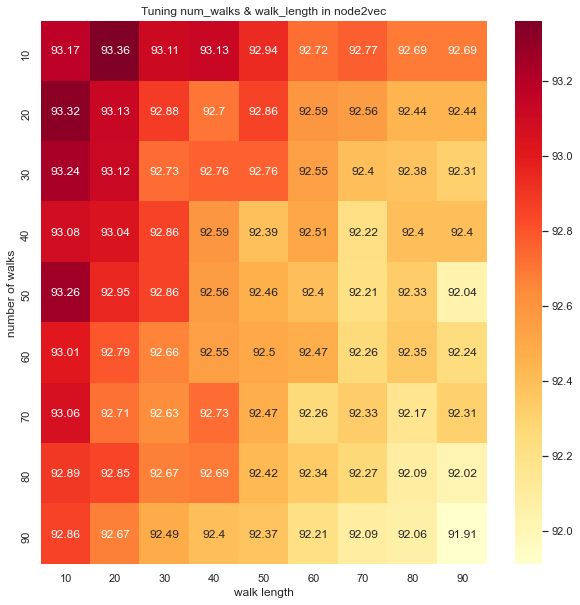

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# show score in (num_of_walks=10-90,walk_length=10-90)
auc = np.zeros([9,9])

data = pd.read_pickle('pkl/1.pkl')
scores = data.get('map_auc_scores')
for i in range(len(scores)):
    auc[int(scores[i][3]/10)-1][int(scores[i][4]/10)-1] = round(scores[i][1]*100,2)

data = pd.read_pickle('pkl/2.pkl')
scores = data.get('map_auc_scores')
for i in range(len(scores)):
    auc[int(scores[i][3]/10)-1][int(scores[i][4]/10)-1] = round(scores[i][1]*100,2)

data = pd.read_pickle('pkl/3.pkl')
scores = data.get('map_auc_scores')
for i in range(len(scores)):
    auc[int(scores[i][3]/10)-1][int(scores[i][4]/10)-1] = round(scores[i][1]*100,2)

#deep,node2vec,node_dim,num_walks,walk_length,num_false_edges,p,q) = map_auc_scores

auc = pd.DataFrame(auc, columns=np.arange(1,10), index=np.arange(1,10))
sns.set()
fig, ax = plt.subplots(figsize=(10,10))
#annot_kws={'size':9}
sns_plot = sns.heatmap(auc,annot=True,ax=ax,cmap='YlOrRd',fmt='g')
ax.set_xticklabels(np.arange(10,91,10))
ax.set_yticklabels(np.arange(10,91,10))

ax.set_title('Tuning num_walks & walk_length in node2vec')
ax.set_xlabel("walk length")
ax.set_ylabel("number of walks")

plt.savefig("10-90.png")

[[92.13 92.95 92.95 93.19 93.24 93.12 93.29]
 [92.99 93.17 93.31 93.36 93.29 93.11 93.14]
 [93.13 93.37 93.32 93.09 93.09 93.33 92.98]
 [93.29 93.32 93.39 93.13 93.23 92.88 92.87]
 [93.2  93.33 93.22 93.04 93.   93.   92.91]
 [93.04 93.24 93.12 93.12 92.93 92.73 92.82]
 [93.25 93.08 93.12 93.04 92.83 92.86 92.76]]


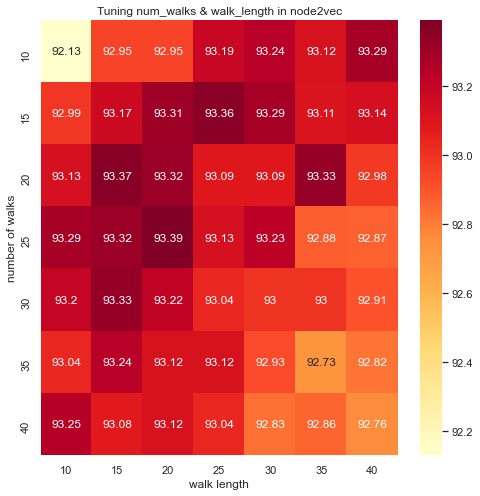

In [82]:
# show score in (num_of_walks=10-40,walk_length=10-40)
auc =  np.zeros([7,7])

data = pd.read_pickle('pkl/1.pkl')
map_auc_scores = data.get('map_auc_scores')
for i in range(len(map_auc_scores)):
    if(map_auc_scores[i][3]<=40 and map_auc_scores[i][4]<=40):
        auc[int(map_auc_scores[i][3]/5)-2][int(map_auc_scores[i][4]/5)-2] = round(map_auc_scores[i][1]*100,2)

data = pd.read_pickle('pkl/2.pkl')
map_auc_scores = data.get('map_auc_scores')
for i in range(len(map_auc_scores)):
     if(map_auc_scores[i][3]<=40 and map_auc_scores[i][4]<=40):
        auc[int(map_auc_scores[i][3]/5)-2][int(map_auc_scores[i][4]/5)-2] = round(map_auc_scores[i][1]*100,2)
    
data = pd.read_pickle('pkl/3.pkl')
map_auc_scores = data.get('map_auc_scores')
for i in range(len(map_auc_scores)):
     if(map_auc_scores[i][3]<=40 and map_auc_scores[i][4]<=40):
        auc[int(map_auc_scores[i][3]/5)-2][int(map_auc_scores[i][4]/5)-2] = round(map_auc_scores[i][1]*100,2)
#deep,node2vec,node_dim,num_walks,walk_length,num_false_edges,p,q) = map_auc_scores

print(auc)

sns.set()
fig, ax = plt.subplots(figsize=(8,8))
#annot_kws={'size':9}
sns_plot = sns.heatmap(auc,annot=True,ax=ax,cmap='YlOrRd',fmt='g')
ax.set_xticklabels(np.arange(10,41,5))
ax.set_yticklabels(np.arange(10,41,5))

ax.set_title('Tuning num_walks & walk_length in node2vec')
ax.set_xlabel("walk length")
ax.set_ylabel("number of walks")

plt.savefig("10-40.png")

[[93.03 93.24 93.12 93.23 93.21]
 [93.19 93.15 93.36 93.28 93.2 ]
 [93.2  93.26 93.23 93.52 93.34]
 [93.3  93.22 93.41 93.18 93.18]
 [93.23 93.35 93.32 92.97 93.14]]


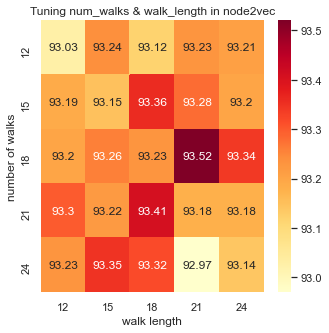

In [85]:
# show score in (num_of_walks=12-24,walk_length=12-24)
auc =  np.zeros([5,5])
    
data = pd.read_pickle('pkl/4.pkl')
map_auc_scores = data.get('map_auc_scores')
for i in range(len(map_auc_scores)):
     if(map_auc_scores[i][3]<=24 and map_auc_scores[i][4]<=24 and map_auc_scores[i][3]>=12 and map_auc_scores[i][4]>=12):
        auc[int(map_auc_scores[i][3]/3)-4][int(map_auc_scores[i][4]/3)-4] = round(map_auc_scores[i][1]*100,2)
#deep,node2vec,node_dim,num_walks,walk_length,num_false_edges,p,q) = map_auc_scores

print(auc)

sns.set()
fig, ax = plt.subplots(figsize=(5,5))
#annot_kws={'size':9}
sns_plot = sns.heatmap(auc,annot=True,ax=ax,cmap='YlOrRd',fmt='g')
ax.set_xticklabels(np.arange(12,25,3))
ax.set_yticklabels(np.arange(12,25,3))

ax.set_title('Tuning num_walks & walk_length in node2vec')
ax.set_xlabel("walk length")
ax.set_ylabel("number of walks")

plt.savefig("12-24.png")